# Bayesian Logistic Regression and the Laplace Approximation

**STATS271/371: Applied Bayesian Statistics** <br>
_Scott Linderman_ <br>
_Stanford University. Winter, 2021._

---

Demo notebook to go along with "Lap 2" lectures.

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats as ss
import autograd.scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.special import expit as logistic
sns.set_context("notebook")

## Simulate random data

In [2]:
# Sample random covariates and data
N = 50
rng = npr.RandomState(0)
xs = rng.normal(size=(N, 2))

# Fix true weights and variance
true_w = np.array([1.0, 1.0])
ys = rng.rand(N) < logistic(xs @ true_w)

## Plot the logistic function

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

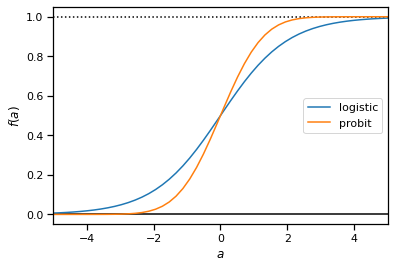

In [10]:
a = np.linspace(-5 ,5)
plt.plot(a, logistic(a), label="logistic")
plt.plot(a, ss.norm.cdf(a), label="probit")
plt.hlines(1, -5, 5, colors='k', linestyles=':')
plt.hlines(0, -5, 5, colors='k', linestyles='-')
plt.xlim(-5, 5)
plt.xlabel("$a$")
plt.ylabel("$f(a)$")
plt.legend(loc="center right")

plt.savefig("logistic_probit.pdf")
files.download('logistic_probit.pdf') 

## Plot the data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

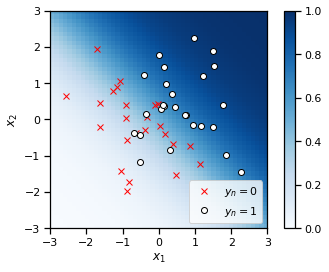

In [11]:
X1, X2 = np.meshgrid(np.linspace(-3, 3), np.linspace(-3, 3))
x1x2 = np.column_stack((X1.ravel(), X2.ravel()))
plt.imshow(logistic(x1x2 @ true_w).reshape(X1.shape), 
           vmin=0, vmax=1, cmap="Blues", extent=(-3, 3, 3, -3))

plt.plot(xs[ys==0, 0], xs[ys==0, 1], 'rx', label="$y_n=0$")
plt.plot(xs[ys==1, 0], xs[ys==1, 1], 'wo', mec='k', mew=1, label="$y_n=1$")
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect("equal")
plt.colorbar()

plt.savefig("data.pdf")
files.download('data.pdf') 

## Plot the log joint probabiliy for a grid of weights


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

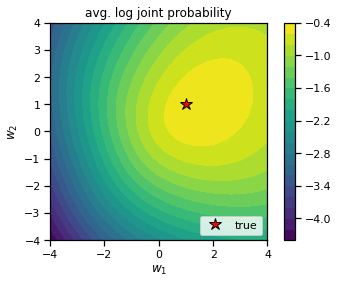

In [12]:
def log_joint(w, sigmasq=1.0):
    act = np.einsum('...p,np->...n', w, xs)
    ll = np.sum(ys * act, axis=-1) - np.sum(np.log1p(np.exp(act)), axis=-1)
    log_prior = -0.5 / sigmasq * np.einsum('...p,...p->...', w, w)
    return ll + log_prior

W1, W2 = np.meshgrid(np.linspace(-4, 4), np.linspace(-4, 4))
w1w2 = np.column_stack((W1.ravel(), W2.ravel()))
w_slice = np.linspace(-4, 4)
lp = log_joint(w1w2).reshape(W1.shape) / N

plt.contourf(W1, W2, lp, 25)
plt.plot(true_w[0], true_w[1], 'r*', mec='k', ms=12, label="true")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("avg. log joint probability")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")
plt.legend(loc="lower right")
plt.colorbar()


plt.savefig("log_joint.pdf")
files.download('log_joint.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

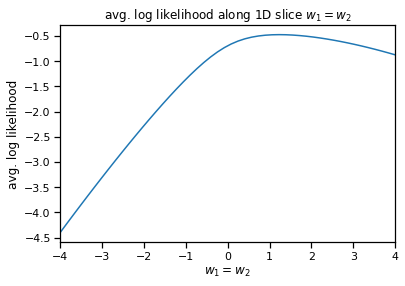

In [13]:
# plot the log likelihood along a 1D slice of this space
lp_slice = log_joint(np.column_stack([w_slice, w_slice])) / N

plt.plot(w_slice, lp_slice)
plt.xlabel("$w_1 = w_2$")
plt.ylabel("avg. log likelihood")
plt.xlim(-4, 4)
plt.title("avg. log likelihood along 1D slice $w_1 = w_2$")

plt.savefig("log_joint_1d.pdf")
files.download('log_joint_1d.pdf') 

## Maximize the log probability with BFGS


In [7]:
from scipy.optimize import minimize
from autograd import grad

# Minimize the log joint. Normalize by N so it's better scaled.
obj = lambda w: -log_joint(w) / N

# Keep track of the weights visited during optimization.
w_init = np.array([-2., -3.])
w_hist = [w_init]
def callback(w):
    w_hist.append(w)

result = minimize(obj, w_init, jac=grad(obj), callback=callback, method="BFGS")
w_hist = np.array(w_hist)
w_map = w_hist[-1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

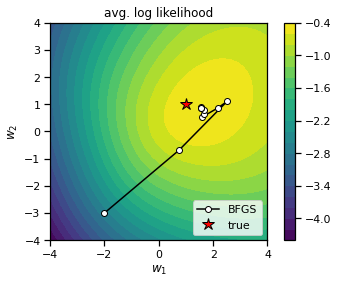

In [14]:
# Plot the contours and the optimization path.
plt.contourf(W1, W2, lp, 25)
plt.plot(w_hist[:, 0], w_hist[:, 1], '-ko', mfc='w', mec='k', mew=1, label="BFGS")
plt.plot(true_w[0], true_w[1], 'r*', mec='k', ms=12, label="true")

plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("avg. log likelihood")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")
plt.legend(loc="lower right")
plt.colorbar()

plt.savefig("bfgs.pdf")
files.download('bfgs.pdf') 

## Compute the Laplace approximation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

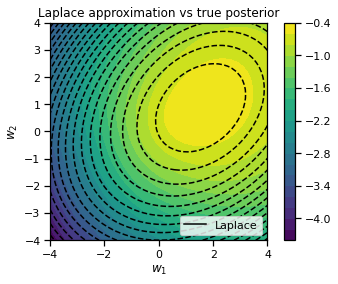

In [15]:
from autograd import hessian
Sigma = -np.linalg.inv(hessian(log_joint)(w_map))
lp_laplace = ss.multivariate_normal.logpdf(w1w2, w_map, Sigma).reshape(W1.shape)
h = plt.contourf(W1, W2, lp, 25)
plt.contour(W1, W2, lp_laplace, 25, colors='k')
plt.plot([], [], '-k', label="Laplace")

plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("Laplace approximation vs true posterior")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")
plt.legend(loc="lower right")
plt.colorbar(h)

plt.savefig("laplace.pdf")
files.download('laplace.pdf') 